In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
#IMPORT DATA
filename='basket/nba_shots.csv'
data=pd.read_csv(filename)
len(data)    
#CLEAN DATA
cdata=data[-np.isnan(data['shot_made_flag'])]

In [19]:
len(cdata)
cdata.columns

Index(['action_type', 'combined_shot_type', 'game_event_id', 'game_id', 'lat',
       'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'season', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'team_id', 'team_name', 'game_date', 'matchup', 'opponent', 'shot_id'],
      dtype='object')

In [20]:
#CHECK CELL
#shot_distance, by combined_shot_type, by shot_zone_area, by period and by minutes_remaining
#cdata['shot_zone_area'].describe

In [21]:
#ANALYSIS BY CATEGORICAL VAR
#combined_shot_type
cdata.groupby('combined_shot_type',as_index=False).agg({"shot_made_flag":"mean"})

,combined_shot_type,shot_made_flag
0,Bank Shot,0.791667
1,Dunk,0.928030
2,Hook Shot,0.535433
3,Jump Shot,0.391071
4,Layup,0.565093
5,Tip Shot,0.348684


In [22]:
#shot_zone_area
cdata.groupby('shot_zone_area',as_index=False).agg({"shot_made_flag":"mean"})

,shot_zone_area,shot_made_flag
0,Back Court(BC),0.013889
1,Center(C),0.525556
2,Left Side Center(LC),0.361177
3,Left Side(L),0.396871
4,Right Side Center(RC),0.382567
5,Right Side(R),0.401658


In [23]:
#period
cdata.groupby('period',as_index=False).agg({"shot_made_flag":"mean"})

,period,shot_made_flag
0,1,0.465672
1,2,0.448802
2,3,0.453442
3,4,0.413702
4,5,0.442857
5,6,0.466667
6,7,0.428571


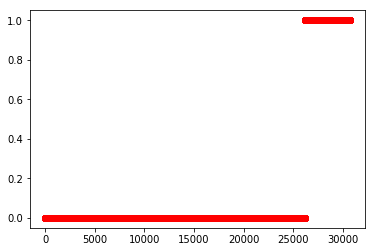

In [29]:
#ANALYSIS BY QUAND VAR
plt.plot(cdata['playoffs'],'ro')

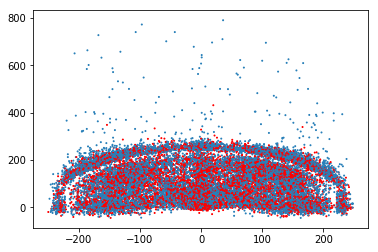

In [25]:
#SHOT LOCATION
c=np.where(cdata['shot_made_flag']==1,"red", "#2980b9")
plt.scatter(cdata['loc_x'],cdata['loc_y'],1,c)

In [122]:
#MODELLING
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [123]:
#PREPROCESSING
var=['combined_shot_type','loc_x', 'loc_y', 'minutes_remaining', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range','shot_id']
mdata=cdata[var]
mdata.isnull().values.any() #CHECK IF THERE IS NAN VALUE IN DATAFRAME

False

In [141]:
#CATEGORICAL DATA LABEL
from sklearn.preprocessing import LabelEncoder
charvar=["combined_shot_type","shot_type","shot_zone_area","shot_zone_basic","shot_zone_range"]
lb_make=LabelEncoder()
def labelizer(mdata,charvar,lb_make) :
    res=mdata
    for name in charvar:
        res[name + str("_label")]=lb_make.fit_transform(mdata[name])
        res=res.drop(name,axis=1)
    return res

tdata=labelizer(mdata,charvar,lb_make)
tdata.head(3)

#mdata["combined_shot_type_label"] = lb_make.fit_transform(mdata["combined_shot_type"])
#mdata["shot_type_label"] = lb_make.fit_transform(mdata["shot_type"])
#mdata["shot_zone_area_label"] = lb_make.fit_transform(mdata["shot_zone_area"])
#mdata['shot_zone_basic_label'] = lb_make.fit_transform(mdata["shot_zone_basic"])
#mdata['shot_zone_range_label'] = lb_make.fit_transform(mdata["shot_zone_range"])

/home/sunghyuk/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,loc_x,loc_y,minutes_remaining,seconds_remaining,shot_distance,shot_made_flag,shot_id,combined_shot_type_label,shot_type_label,shot_zone_area_label,shot_zone_basic_label,shot_zone_range_label
1,-157,0,10,22,15,0.0,2,3,0,3,4,2
2,-101,135,7,45,16,1.0,3,3,0,2,4,0
3,138,175,6,52,22,0.0,4,3,0,4,4,0


In [187]:
train,test=train_test_split(tdata,test_size=0.3)

In [188]:
def xysplit(data,target_var):
    Y=pd.DataFrame(data[target_var])
    X=data.drop(target_var,axis=1)
    return X,Y

In [189]:
X_train,Y_train=xysplit(train,'shot_made_flag')
X_test,Y_test=xysplit(test,'shot_made_flag')

In [190]:
rf=RandomForestClassifier()
rf.fit(X_train,Y_train)

/home/sunghyuk/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/sunghyuk/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [191]:
import sklearn.metrics as met
def perf(X,Y,model):
    print(met.accuracy_score(Y,model.predict(X)))
    print(met.confusion_matrix(Y,model.predict(X)))
    return

In [192]:
#TRAINING DATA
perf(X_train,Y_train,rf)

0.9776505253794407
[[9882   49]
 [ 353 7703]]


In [193]:
#TEST DATA
perf(X_test,Y_test,rf)

0.5744487678339818
[[3163 1138]
 [2143 1266]]


In [194]:
#GRID SEARCH
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [195]:
# comment SPLIT DATA TRAIN/DEV/TEST SET

#train,dev=train_test_split(tdata,test_size=0.3)
#dev,test=train_test_split(dev,test_size=0.4)
#print(len(train),len(dev),len(test))
#X_train,Y_train=xysplit(train,'shot_made_flag')
#X_dev,Y_dev=xysplit(dev,'shot_made_flag')
#X_test,Y_test=xysplit(dev,'shot_made_flag')

In [196]:
grid_search.fit(X_train,Y_train)
# 12min

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 11.3min finished
/home/sunghyuk/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110], 'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': [100, 200, 300, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [209]:
#TRAIN DATA SET
print(grid_search.best_params_)
rf_opt=grid_search.best_estimator_
perf(X_train,Y_train,rf_opt)

{'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 1000}
0.8024684494357036
[[8869 1062]
 [2491 5565]]


In [210]:
#TEST DATA SET
perf(X_test,Y_test,rf_opt)

0.5948119325551232
[[3348  953]
 [2171 1238]]


In [199]:
#ACTUALLY NO NEED OF DEV SET
#X_TEST=pd.concat([X_dev,X_test])
#Y_TEST=pd.concat([Y_dev,Y_test])
from sklearn.ensemble import AdaBoostClassifier
adb=AdaBoostClassifier()
adb.fit(X_train,Y_train)

/home/sunghyuk/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [200]:
perf(X_test,Y_test,adb)

0.6107652399481194
[[3662  639]
 [2362 1047]]


In [217]:
adb_param_grid={
    'learning_rate':[0.5],
    'n_estimators': [50,100,150]
}

adb_grid=GridSearchCV(estimator = adb, param_grid = adb_param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [218]:
adb_grid.fit(X_train,Y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.4s finished
/home/sunghyuk/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.5], 'n_estimators': [100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [219]:
print(adb_grid.best_estimator_)
adb_opt=adb_grid.best_estimator_
perf(X_test,Y_test,adb_opt)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=100, random_state=None)
0.609727626459144
[[3667  634]
 [2375 1034]]
